In [46]:
%pip install torchmetrics --quiet

Note: you may need to restart the kernel to use updated packages.


# MNIST Dataset

1. Escalar las imágenes en un rango de [0,1]. 
2. Usar 10% del conjunto de prueba para validación en el entrenamiento. 
3. Usar como función de perdida categorical_crossentropy, optimizador adam y métrica exactitud durante el entrenamiento de 15 épocas. 
4. Aplicar zero-padding en las capas conv2d. Reportar valor de perdida y exactitud para entrenamiento y prueba.

![Red](./variety/red.png)

In [47]:
import torch

ngpu = torch.cuda.device_count()

device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
device

device(type='cuda', index=0)

In [56]:
!nvidia-smi

Thu May  4 20:03:06 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.73.05    Driver Version: 510.73.05    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro P5000        Off  | 00000000:00:05.0 Off |                  Off |
| 26%   28C    P8     6W / 180W |    923MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [48]:
import torchvision.datasets as datasets
from torchvision import transforms

# Normalizamos las imágenes en rango de 0 y 1
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Cargar dataset y normalizar
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

In [49]:
from torch.utils.data import random_split

# Usar 10% del conjunto de prueba para validación en el entrenamiento. 
test_dataset_size = len(mnist_testset)

validation_size = int(test_dataset_size * 0.1)
test_size = test_dataset_size - validation_size

mnist_validationset, mnist_testset = random_split(mnist_testset, [validation_size, test_size])

print(f"Tamaño del conjunto de entrenamiento: {len(mnist_trainset)}")
print(f"Tamaño del conjunto de prueba: {len(mnist_testset)}")
print(f"Tamaño del conjunto de validación: {len(mnist_validationset)}")

Tamaño del conjunto de entrenamiento: 60000
Tamaño del conjunto de prueba: 9000
Tamaño del conjunto de validación: 1000


In [50]:
from torch.utils.data import DataLoader

batch_size = 64

# Crear los conjuntos de entrenamiento, prueba y validación
train_data = DataLoader(dataset=mnist_trainset, 
                        batch_size=batch_size,
                        num_workers=2,
                        shuffle=True)

test_data = DataLoader(dataset=mnist_trainset, 
                        batch_size=batch_size,
                        num_workers=2)

val_data = DataLoader(dataset=mnist_validationset, 
                        batch_size=batch_size,
                        num_workers=2)

![Red](./variety/red.png)

a) Implemente la CNN del diagrama omitiendo las capas dropout e implemente EarlyStopping monitoreando la perdida del conjunto de
validación y una paciencia de 2.

In [52]:
import torch
import torch.nn as nn

class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(3, 3), stride=1, padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Flatten(),
            nn.Linear(in_features=9216, out_features=128),
            nn.Linear(in_features=128, out_features=10),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        return self.conv(x)

model = CNN(num_classes=10).to(device)
print(model)

CNN(
  (conv): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Flatten(start_dim=1, end_dim=-1)
    (6): Linear(in_features=784, out_features=128, bias=True)
    (7): Linear(in_features=128, out_features=10, bias=True)
    (8): Softmax(dim=1)
  )
)


In [53]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [54]:
from pytorchtools import EarlyStopping
import numpy as np

from torchmetrics.classification import Accuracy

def train_model(model, patience, epochs):
    train_losses = []
    valid_losses = []
    avg_train_losses = []
    avg_valid_losses = []

    metric = Accuracy(task="multiclass", num_classes=10)

    early_stopping = EarlyStopping(patience=patience, verbose=True)

    
    for epoch in range(epochs):
        model.train()

        running_loss = 0.0
        running_acc = 0.0

        # Train the model
        for batch, (data, target) in enumerate(train_data, 1):

            data = data.to(device)
            target = target.to(device)

            optimizer.zero_grad()

            output = model(data)

            loss = criterion(output, target)

            loss.backward()
            
            optimizer.step()

            train_losses.append(loss.item())

            running_loss += loss.item()
            if batch % 1000 == 999:
                print(f"[{epoch+1}, {batch}] loss: {running_loss/1000:.3f}")
                running_loss = 0.0



        with torch.no_grad():
            # Validate the model
            model.eval()
            for data, target in val_data:
                data = data.to(device)
                target = target.to(device)

                output = model(data)
                loss = criterion(output, target)
                valid_losses.append(loss.item())

                batch_accuracy = metric(output.to('cpu'), target.to('cpu'))
                print(f"Accuracy: {batch_accuracy:.3f}")
                
            train_loss = np.average(train_losses)
            valid_loss = np.average(valid_losses)
            avg_train_losses.append(train_loss)
            avg_valid_losses.append(valid_loss)

            epoch_len = len(str(epochs))
                
            print_msg = (f'[{epoch:>{epoch_len}}/{epochs:>{epoch_len}}] ' +
                        f'train_loss: {train_loss:.5f} ' +
                        f'valid_loss: {valid_loss:.5f}')
            
            print(print_msg)

            train_losses = []
            valid_losses = []
                
            early_stopping(valid_loss, model)
            
            if early_stopping.early_stop:
                print("Early stopping")
                break
    
    model.load_state_dict(torch.load('checkpoint.pt'))

    return model, avg_train_losses, avg_valid_losses

In [55]:
patience = 20
model, train_loss, valid_loss = train_model(model, patience, 15)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (64x9216 and 784x128)

In [ ]:
import matplotlib.pyplot as plt

# visualize the loss as the network trained
fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(train_loss)+1),train_loss, label='Training Loss')
plt.plot(range(1,len(valid_loss)+1),valid_loss,label='Validation Loss')

# find position of lowest validation loss
minposs = valid_loss.index(min(valid_loss))+1 
plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

plt.xlabel('epochs')
plt.ylabel('loss')
plt.ylim(0, 0.5) # consistent scale
plt.xlim(0, len(train_loss)+1) # consistent scale
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
fig.savefig('loss_plot.png', bbox_inches='tight')

# MNIST Dataset

In [13]:
import torch

ngpu = torch.cuda.device_count()

device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
device

device(type='cuda', index=0)

In [15]:
from torch.utils.data import random_split

# Usar 10% del conjunto de prueba para validación en el entrenamiento. 
test_dataset_size = len(mnist_testset)

validation_size = int(test_dataset_size * 0.1)
test_size = test_dataset_size - validation_size

mnist_validationset, mnist_testset = random_split(mnist_testset, [validation_size, test_size])

print(f"Tamaño del conjunto de entrenamiento: {len(mnist_trainset)}")
print(f"Tamaño del conjunto de prueba: {len(mnist_testset)}")
print(f"Tamaño del conjunto de validación: {len(mnist_validationset)}")

Tamaño del conjunto de entrenamiento: 60000
Tamaño del conjunto de prueba: 9000
Tamaño del conjunto de validación: 1000


![Red](https://neji3cswyd.clg07azjl.paperspacegradient.com/files/red.png?token=df62b5170a9372b81ef5eae580c731a5)

In [29]:
import torch
import torch.nn as nn

class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(3, 3), stride=1, padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Flatten(),
            nn.Linear(in_features=9216, out_features=128),
            nn.Linear(in_features=128, out_features=10),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        return self.conv(x)

model = CNN(num_classes=10).to(device)
print(model)

CNN(
  (conv): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Flatten(start_dim=1, end_dim=-1)
    (6): Linear(in_features=9216, out_features=128, bias=True)
    (7): Linear(in_features=128, out_features=10, bias=True)
    (8): Softmax(dim=1)
  )
)


In [42]:
from pytorchtools import EarlyStopping
import numpy as np

from torchmetrics.classification import Accuracy

def train_model(model, patience, epochs):
    train_losses = []
    valid_losses = []
    avg_train_losses = []
    avg_valid_losses = []

    metric = Accuracy(task="multiclass", num_classes=10)

    early_stopping = EarlyStopping(patience=patience, verbose=True)

    
    for epoch in range(epochs):
        model.train()

        running_loss = 0.0
        running_acc = 0.0

        # Train the model
        for batch, (data, target) in enumerate(train_data, 1):

            data = data.to(device)
            target = target.to(device)

            optimizer.zero_grad()

            output = model(data)

            loss = criterion(output, target)

            loss.backward()
            
            optimizer.step()

            train_losses.append(loss.item())

            running_loss += loss.item()
            if batch % 1000 == 999:
                print(f"[{epoch+1}, {batch}] loss: {running_loss/1000:.3f}")
                running_loss = 0.0



        with torch.no_grad():
            # Validate the model
            model.eval()
            for data, target in val_data:
                data = data.to(device)
                target = target.to(device)

                output = model(data)
                loss = criterion(output, target)
                valid_losses.append(loss.item())

                batch_accuracy = metric(output.to('cpu'), target.to('cpu'))
                print(f"Accuracy: {batch_accuracy:.3f}")
                
            train_loss = np.average(train_losses)
            valid_loss = np.average(valid_losses)
            avg_train_losses.append(train_loss)
            avg_valid_losses.append(valid_loss)

            epoch_len = len(str(epochs))
                
            print_msg = (f'[{epoch:>{epoch_len}}/{epochs:>{epoch_len}}] ' +
                        f'train_loss: {train_loss:.5f} ' +
                        f'valid_loss: {valid_loss:.5f}')
            
            print(print_msg)

            train_losses = []
            valid_losses = []
                
            early_stopping(valid_loss, model)
            
            if early_stopping.early_stop:
                print("Early stopping")
                break
    
    model.load_state_dict(torch.load('checkpoint.pt'))

    return model, avg_train_losses, avg_valid_losses

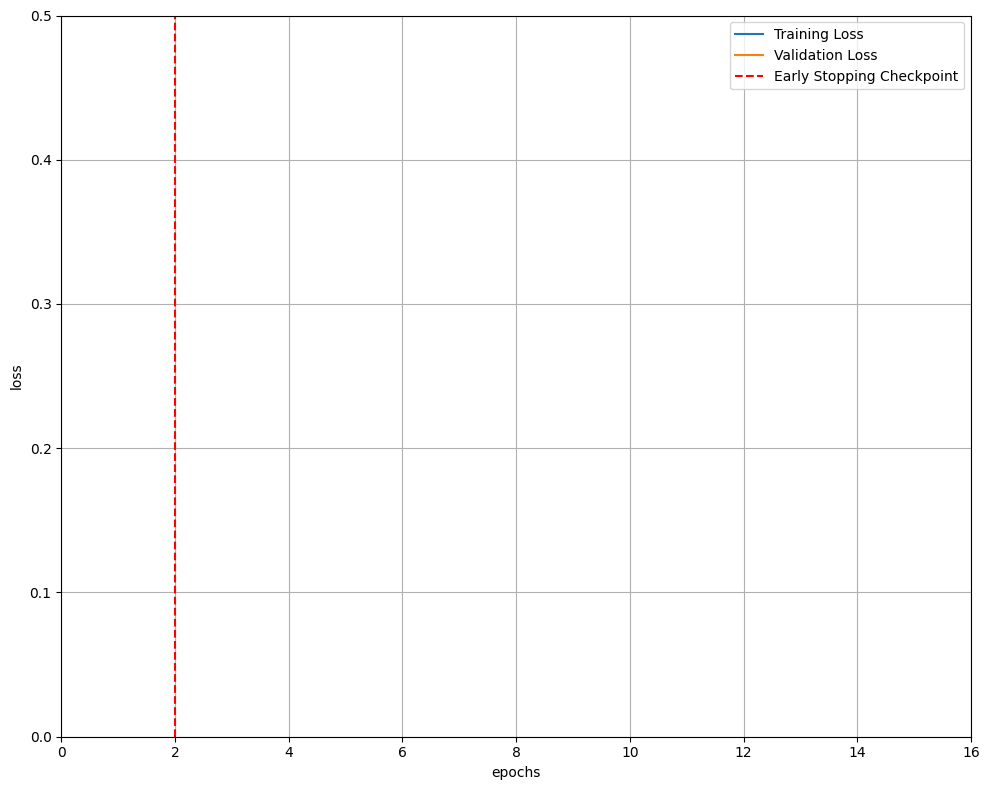

In [45]:
import matplotlib.pyplot as plt

# visualize the loss as the network trained
fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(train_loss)+1),train_loss, label='Training Loss')
plt.plot(range(1,len(valid_loss)+1),valid_loss,label='Validation Loss')

# find position of lowest validation loss
minposs = valid_loss.index(min(valid_loss))+1 
plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

plt.xlabel('epochs')
plt.ylabel('loss')
plt.ylim(0, 0.5) # consistent scale
plt.xlim(0, len(train_loss)+1) # consistent scale
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
fig.savefig('loss_plot.png', bbox_inches='tight')